# I. Data loading & preprocessing
## 1) set parameters & paths

In [1]:
#from jupyterthemes import jtplot
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
#jtplot.style(theme='onedork',context='paper',fscale=1,spines=True,gridlines='--',ticks=True,grid=True)

from lupy import *
from lufil import *
from scipy import interpolate
from scipy.stats import kurtosis
from scipy.linalg import circulant
import os
import sys
import time
import math
import shutil
import multiprocessing
import numpy as np
import cv2 as cv
import scipy.io as sio
import SimpleITK as sitk
import matplotlib.pyplot as plt
import matplotlib.colors as col
import matplotlib.cm as cm
from matplotlib.patches import Circle
from scipy.ndimage.filters import gaussian_filter, gaussian_filter1d

# CTP parameters
PRE = 10
POST = 50
loth = 0
hith = 120
rho = 1.04

# filtering
sigma1d = 0.9
sigma2d = 0.9
window = 5

# multiprocessing
def multi_proc(func, args, n_core):
    start = time.time()
    p = multiprocessing.Pool(10)
    out = p.map_async(func, args).get()
    p.close()
    p.join()
    tcost = time.time() - start
    print('Done, used',int(tcost/60),'mins', int(tcost%60),'seconds')
    return out

In [2]:
# set path
data_path = '../data/dcm'
output_path = '../data/output'

# Select patients
if len(sys.argv) == 2:
    patient_name = sys.argv[1]
else:
    patient_name = input('Please enter the patient\'s name: ')
files = fsearch(path = data_path, suffix='.nii', include=patient_name, sort_level=-1)
fname = files[0]

# Create output folder if not existed
output_path = os.path.join(output_path, patient_name)
if len(files) == 1 and not os.path.exists(output_path):
    os.makedirs(output_path)

Please enter the patient's name: luminda


## 2.a) Load previously saved time corrected & downsampled(z-axis) array

In [3]:
# Load interpolated array from previously saved mat file
print('Loading time corrected data from previously saved mat file')
arr_itp = sio.loadmat(output_path+'/arr_itp.mat')['arr_itp']
print(arr_itp.shape)

Loading time corrected data from previously saved mat file
(61, 10, 512, 512)


## 2.b) Load raw data and perform downsampling and time correction

In [ ]:
# load data from nifti
#arr_itp = sitk.GetArrayFromImage(sitk.ReadImage('../data/case_3.nii'))
#print('shape:', arr_itp.shape, ', dtype:', arr_itp.dtype,"max=", np.max(arr_itp),", min=", np.min(arr_itp))

In [ ]:
# find all series and load chosen series
folder = os.path.join(data_path, patient_name)
print(folder)
series_IDs = list(sitk.ImageSeriesReader.GetGDCMSeriesIDs(folder)) # only contain one series as prepared
series_file_names = list(sitk.ImageSeriesReader.GetGDCMSeriesFileNames(folder, series_IDs[0]))
print(len(series_IDs),'series IDs found, ', len(series_file_names),'slices.')
print('\n'.join(series_IDs))

# sort the slices according to instance number
print('Loading all slicess...')
series_file_names.sort(key=lambda x:int(sitk.ReadImage(x).GetMetaData(key='0020|0013')))

# check number of slices and number of time points
print('Checking number of slices and time points...')
origins = []
c = []
total = len(series_file_names)
for x in series_file_names:
    d = sitk.ReadImage(x).GetOrigin()[2]
    t = float(sitk.ReadImage(x).GetMetaData(key='0008|0033'))
    if not d in origins:
        origins.append(d)
        c.append([t])
    else:
        idx = origins.index(d)
        c[idx].append(t)

avgs = []
for i in range(len(origins)):
    c[i] = sorted(c[i])
    for j in range(1,len(c[i])):
        c[i][j-1] =round(c[i][j] - c[i][j-1], 2)
    c[i] = c[i][0:-1]
    c[i].remove(max(c[i]))
    avg = (round(sum(c[i])/len(c[i]), 2))
    avgs.append(avg)
    
dt = round(sum(avgs)/len(avgs), 2)
print('\nDone, average interval between scans: '+str(dt)+'s')

# get the original array
print('Loading original pixel array...')
series_reader = sitk.ImageSeriesReader()
series_reader.SetFileNames(series_file_names)
image3D = series_reader.Execute()
arr_raw = sitk.GetArrayFromImage(image3D)

# reshape to 4D
print('Reshaping to 4d array...')
nz = len(origins)
nt = len(series_file_names)//nz
nx = arr_raw.shape[1]
ny = arr_raw.shape[2]
arr_raw = np.reshape(arr_raw, (nt, nz, nx, ny))
print('arr_raw shape:', arr_raw.shape, 'dtype:', arr_raw.dtype)

# downsample in z-axis to reduce computation
step = round(nz/10)
arr_raw = arr_raw[:, np.arange(0,nz,step), :, :]
print('Downsampled to :',arr_raw.shape, 'dtype:', arr_raw.dtype)

In [ ]:
# Interpolation
def interp(args):
    [sig, times, times_new] = args
    f = interpolate.interp1d(times, sig, kind='linear', fill_value="extrapolate")
    return f(times_new)

# parameters for interpolation
[nt, nz, nx, ny] = arr_raw.shape
nt_new = round((nt-1)*dt+1)
times = np.linspace(0, nt-1, nt)
times_new = np.linspace(0, nt-1, nt_new)

# run interpolation with multiprocessing
print('Interpolating from '+str(nt)+' to '+str(nt_new)+' time points...')
args = [(arr_raw[:,z,x,y], times, times_new) for z in range(nz) for x in range(nx) for y in range(ny)]
arr_itp = multi_proc(interp, args, 10)

# convert result to array
print('Done, converting result to array...')
nt = nt_new
arr_itp = np.array(arr_itp)
arr_itp = arr_itp.reshape(nz,nx,ny,nt)
arr_itp = np.moveaxis(arr_itp, -1, 0)
print('Done, shape:',arr_itp.shape, 'dtype:',arr_itp.dtype, 'max=', np.max(arr_itp), 'min=', np.min(arr_itp))

print('Saving as mat file...', end='')
sio.savemat(output_path+'/arr_itp.mat', mdict={'arr_itp': arr_itp})
print('done')

# check interpolation result on a sample voxel
fig,ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(arr_raw[:,0,256,256])
ax[1].plot(arr_itp[:,0,256,256])
plt.show()
plt.close()

## 3) Preprocessing to the interpolated data

In [ ]:
# gaussian 2d filtering
def spatial_gaussian(arr, sigma):
    nt,nz,nx,ny = arr.shape
    for t in range(nt):
        for z in range(nz):
            arr[t,z,:,:] = gaussian_filter(arr[t,z,:,:], sigma)
    return arr

# find mask of bone and bone only
def get_mask_old(arr, loth, hith):
    arr[arr>120]=0
    return np.where(arr>0, 1, 0)

# find mask of bone and area outside of bone
def get_mask(arr, loth, hith):
    [nz, nx, ny] = arr.shape
    tmp0 = np.where(arr<loth, 0, 1)
    tmp1 = np.where(arr>hith, 0, 1 )
    tmp2 = tmp1
    for z in range (nz):
        for x in range(nx):
            L,R = ny//2, ny//2
            idx = np.where(tmp1[z,x,:]==0)[0]
            if len(idx)>0:
                L=idx[0]
                R=idx[-1]
            tmp1[z,x,0:L] = 0
            tmp1[z,x,R:-1] = 0
        for y in range(ny):
            B,U = nx//2, nx//2
            idx = np.where(tmp2[z,:,y]==0)[0]
            if len(idx)>0:
                U=idx[0]
                B=idx[-1]
            tmp2[z,0:U,y] = 0
            tmp2[z,B:-1,y] = 0
    return tmp0*tmp1*tmp2

arr = np.copy(arr_itp)
[nt,nz,nx,ny] = arr.shape

# spatial filtering
print('Spatial filtering...', end='')
arr = spatial_gaussian(arr, sigma2d)
print('done!')

# time filtering
print('Time filtering...', end='')
arr = gaussian_filter1d(arr, sigma1d, axis=0)
print('done!')

# get base
print('Getting base image...', end='')
base = np.mean(arr[0:PRE,:,:,:], axis=0)
print('done!')

# get mask
print('Getting mask...', end='')
mask = get_mask(base, loth, hith)
mask = np.array([mask]*nt)
print('done!')

# get contrast concentration
print('Converting to contrast concentration...', end='')
C = (arr-base)*mask
print('done!')

# segmentation: set non-interested region to 0 or minimum intensity
#arr = arr*mask
print('Segmenting...', end='')
arr[np.where(mask==0)]=np.min(arr)
print('done!')

# check results of bone removal on a sample slice
fig, ax = plt.subplots(1,2, figsize=(10,5))
arr_clip = np.clip(arr_itp, loth, hith)
ax[0].imshow(arr_clip[0,3,:,:], cmap='gray')
arr_clip = np.clip(arr, 0, 120)
ax[1].imshow(arr_clip[0,3,:,:], cmap='gray')
plt.show()
plt.close()

# II. Selection of AIF & VOF

## 1) Manual selection of AIF & VOF (Not working)

In [ ]:
def call_back(event):
    '''
    desc:
        鼠标移动触发的回调函数
        如果点在更换颜色时出现坐标轴抖动,可以通过限制xmin xmax ymin ymax来锁定坐标轴范围
    param:
        event : 指下面的motion_notify_event(鼠标移动)事件
        event.xdata : 事件(鼠标)在图的坐标系统中的x轴坐标
        event.ydata : 事件(鼠标)在图的坐标系统中的y轴坐标
        distance : 这里为了减少运算量直接使用了1范数距离
        0.2        需要根据实际情况修改
    return:
        None
    '''
    try:
        distance0 = list(abs(x - event.xdata) + abs(y - event.ydata))  # 注意:这里会出现当鼠标移出绘图区域的时候会报错,所以try一下
        distance = min(distance0)
        if distance < 0.2:  # 这里的0.2是根据比例尺自己写的,需要根据实际情况修改
            # 这里的scatter相当于在原图的基础上添加散点(原散点保留不变)
            inde = distance0.index(distance)  # inde distance最小值对应的x,y中的索引值
            # 恢复原图颜色
            ax.imshow(np.clip(base[5],0,120), cmap='gray')
            # 更新鼠标最近点颜色
            ax.scatter(inde[0],inde[1],c='white',edgecolors='red') # edgecolors : 边缘颜色变为红色,填充颜色变为白色,覆盖之前的颜色,c和color参数是一回事
            # 添加标注
            plt.text(
                x[inde],
                y[inde],
                f'({x[inde]},{y[inde]})',  # 显示文本内容
                fontsize = 10,  # 文字大小
            ) 
            # 更新画板,否则上面的效果都出不来
            fig.canvas.draw()
    except:
        pass
    
# qt5模式才有交互效果
%matplotlib qt5

# 解决汉字乱码
import matplotlib as mpl

# 字体会按照列表依次从电脑中查找,直到找到
plt.rcParams['font.family'] = ['Arial Unicode MS','Microsoft YaHei','SimHei','sans-serif']
plt.rcParams['axes.unicode_minus'] = False  #解决黑体符号乱码
# 样式美化,可删除(实际接了个背景格子)
# plt.style.use('seaborn')
 
fig, ax = plt.subplots()
ax.imshow(np.clip(base[5],0,120), cmap='gray')

# 鼠标单击(触发)事件
fig.canvas.mpl_connect('button_press_event', call_back)
# 鼠标释放事件
# fig.canvas.mpl_connect('button_release_event', call_back)
# 鼠标移动事件
#fig.canvas.mpl_connect('motion_notify_event', call_back)
 
plt.show()

## 2) Automatic selection of AIF & VOF

In [ ]:
#----------------------------- Automatic AIF/VOF selection -------------------------------#
# fucntion for auto-selecting aif/vof
def autoaif(arg):
    [loc, sig, base] = arg
    r = np.zeros((len(sig)), dtype = np.int16)
    if 0 < base < 120:
        sig = sig - base
        imax = np.argmax(sig)
        if 10 < imax < 40:
            kur = kurtosis(sig, fisher=True)
            if -1 < kur < 1.5:
                r = sig
    return r, loc

print('Searching for AIF & VOF candidates...')
x_step, y_step = 1, 1
args = [((z,x,y), arr[:,z,x,y], base[z,x,y]) for z in range(nz) for x in range(0,nx,x_step) for y in range(0,ny,y_step)]
sigs = multi_proc(autoaif, args, 10)

In [ ]:
# finds AIF & VOF shaped curves
m = max([np.max(x[0]) for x in sigs])
ttp = [x for x in sigs if np.max(x[0]) > m*0.5]
ttp = sorted(ttp, key=lambda x:np.max(x[0]), reverse=True)
ttps = sorted(ttp[0:int(len(ttp)*0.3)], key=lambda x:int(np.argmax(x[0])))
aif_cand = sorted(ttps[0:int(len(ttps)*0.1)], key=lambda x:np.max(x[0]), reverse=True)
vof_cand = sorted(ttps[-(int(len(ttps)*0.1)):-1], key=lambda x:np.max(x[0]), reverse=True)
ttps = np.asarray(ttps)
print(ttps.shape[0],'points found')

In [ ]:
# get AIF & VOF candidates
n_cors = 15
aifcors = [x[1] for x in ttps[0:n_cors]]
vofcors = [x[1] for x in vof_cand[0:n_cors]]
aifs = np.array([x[0] for x in ttps[0:15]])
vofs = np.array([x[0] for x in vof_cand[0:15]])

# locate the selected voxels and plot the contrast concentration
fig,axe = plt.subplots(n_cors,3, figsize=(15,5*n_cors))
for i in range(n_cors):
    aif = aifs[i]
    vof = vofs[i]
    [az,ax,ay] = aifcors[i]
    [vz,vx,vy] = vofcors[i]
    axe[i,0].set_title('#'+str(i)+' Slice '+str(az)+' AIF')
    axe[i,0].imshow(np.clip(arr[0,az,:,:],0,120), cmap='gray')
    axe[i,0].add_patch(Circle((ax,ay),6,color='red'))
    axe[i,0].axis('off')
    axe[i,1].set_title('#'+str(i)+' Slice '+str(vz)+' VOF')
    axe[i,1].imshow(np.clip(arr[0,vz,:,:],0,120), cmap='gray')
    axe[i,1].add_patch(Circle((vx,vy),6,color='blue'))
    axe[i,1].axis('off')
    axe[i,2].set_title('#'+str(i)+' Slice '+str(vz)+' TAC')
    axe[i,2].plot(aifs[i], color='red', label='AIF')
    axe[i,2].plot(vofs[i], color='blue', label='VOF')
    axe[i,2].set_aspect(0.1)
    axe[i,2].legend()

In [ ]:
# plot AIF & VOF
aif = np.mean(aifs, axis = 0)
vof = np.mean(vofs, axis = 0)
plt.plot(aif)
plt.plot(vof)
kav = np.sum(aif)/np.sum(vof)
AIF = aif*(np.sum(vof)/np.sum(aif))
plt.plot(AIF)
plt.show()
#sio.savemat(output_path+'/'+patient_name+'.mat', mdict={'img_mat':arr_raw, 'AIF':aif, 'VOF': vof })
sio.savemat(output_path+'/'+patient_name+'.mat', mdict={'img_mat':arr, 'AIF':aif, 'VOF': vof })

# III. Calculation of feature maps & mismatch
## 1) Calculate residual functions

In [ ]:
def get_invAIF(aif, lamb):
    l = len(aif)
    aif = np.hstack((aif, np.zeros(l)))
    aif = circulant(aif)
    U,s,V = np.linalg.svd(aif)
    th = np.max(s)*lamb
    S = np.diag(s)
    invS = np.linalg.pinv(S) 
    truncation_mask = np.where(S<th, 0, 1)
    tinvS = invS*truncation_mask
    invAIF = (V.T).dot(tinvS).dot(U.T)
    return invAIF

def ctSVD(arg):
    [invAIF, tac] = arg
    l = len(tac)
    tac = np.hstack((tac, np.zeros(l)))  
    return invAIF.dot(tac)[0:l] 

# SVD parameters
lamb = 0.2

# calculate residual function
invAIF = get_invAIF(AIF[PRE:POST], lamb)
args = [(invAIF, C[PRE:POST,z,x,y]) for z in range(nz) for x in range(nx) for y in range(ny)]
R = multi_proc(ctSVD, args, 10)

# convert result to array
nt_trunc = len(R[0])
R = np.array(R).reshape(nz,nx,ny,nt_trunc)
R = np.moveaxis(R, -1, 0)
print('shape:',R.shape, 'dtype:',R.dtype, 'max=', np.max(R), 'min=', np.min(R))
sio.savemat(output_path+'/R.mat', mdict={'R':R, 'arr':arr, 'C': C, 'mask':mask})

In [ ]:
sio.savemat(output_path+'/R.mat', mdict={'R':R, 'arr':arr, 'C': C, 'mask':mask})

## 2) Calculate feature maps & mismatch

In [4]:
R = sio.loadmat(output_path+'/R.mat')['R']
arr = sio.loadmat(output_path+'/R.mat')['arr']
C = sio.loadmat(output_path+'/R.mat')['C']
mask = sio.loadmat(output_path+'/R.mat')['mask']

(10, 512, 512) (10, 512, 512) (10, 512, 512) (10, 512, 512) 39 0


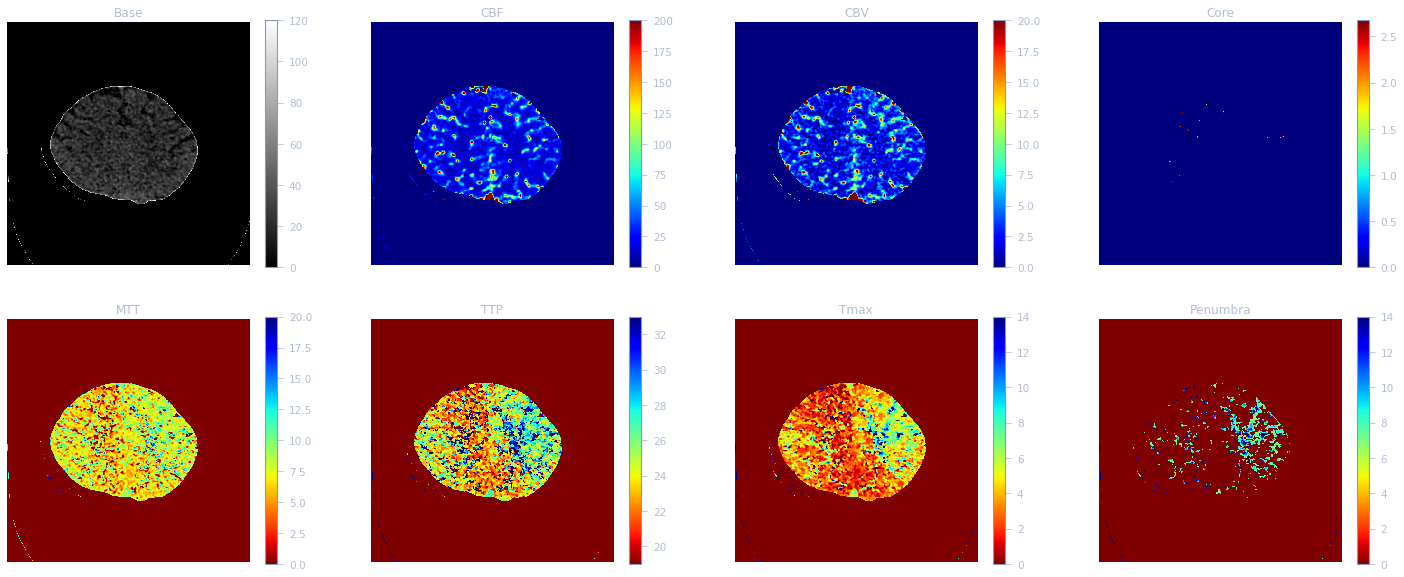

mismatch = 0.06 ,volume difference = -1813540


In [23]:
khema = (1-0.25)/(1-0.45)

CBF = 60*100*khema*np.amax(R, axis = 0)/1.04
CBV = 100*khema*np.sum(R, axis = 0)/1.04
#CBV = 100*khema*(np.sum(arr[10:45,:,:,:], axis=0)/np.sum(AIF[10:45]))/1.04
MTT = CBV*60/(CBF+0.000000000000001)
TTP = np.argmax(arr, axis = 0)
Tmax = np.argmax(R, axis = 0)
print(CBF.shape, CBV.shape, MTT.shape, Tmax.shape, np.max(Tmax), np.min(Tmax))

# save output
img = sitk.GetImageFromArray(CBF.astype(np.int16))
sitk.WriteImage(img, os.path.join(output_path,patient_name)+'_CBF.nii')
img = sitk.GetImageFromArray(CBV.astype(np.int16))
sitk.WriteImage(img, os.path.join(output_path,patient_name)+'_CBV.nii')
img = sitk.GetImageFromArray(MTT.astype(np.int16))
sitk.WriteImage(img, os.path.join(output_path,patient_name)+'_MTT.nii')
img = sitk.GetImageFromArray(Tmax.astype(np.int16))
sitk.WriteImage(img, os.path.join(output_path,patient_name)+'_Tmax.nii')
img = sitk.GetImageFromArray(TTP.astype(np.int16))
sitk.WriteImage(img, os.path.join(output_path,patient_name)+'_TTP.nii')

# window width settings
CBF = np.clip(CBF, 0, 200)
CBV = np.clip(CBV, 0, 20)
MTT = np.clip(MTT, 0, 20)
TTP = np.clip(TTP, 19, 33)
Tmax = np.clip(Tmax, 0, 14)

#core_th = np.max(CBF)*0.3
core_th = np.mean(CBF)*0.3
core = np.where(CBF<core_th, 1, 0)*CBF
penumbra = np.where(Tmax>6, 1, 0)*Tmax
core = np.clip(core, 0, 200)
penumbra = np.clip(penumbra, 0, 14)

# filtering
#CBF = gaussian_filter(CBF, 2)
#CBV = gaussian_filter(CBV, 2)
#MTT = gaussian_filter(MTT, 2)
#TTP = gaussian_filter(TTP, 2)
#Tmax = gaussian_filter(Tmax, 2)
#core = gaussian_filter(core, 2)
#penumbra = gaussian_filter(penumbra, 2)

# plot feature maps and lesion segmentation
slice_i = 9
fig, ax = plt.subplots(2,4,figsize=(25,10))
cbar = ['blue','cyan','green','orange','red']

ct = col.LinearSegmentedColormap.from_list('ct',cbar)
cbar.reverse()
ct_r = col.LinearSegmentedColormap.from_list('ct_r',cbar)
cm.register_cmap(cmap=ct)
cm.register_cmap(cmap=ct_r)

C = np.clip(C*mask, 0, 120)
#cax = ax[0,0].imshow(np.sum(C[:,slice_i,:,:], axis=0), cmap='jet')
cax = ax[0,0].imshow(np.clip(arr[0,slice_i,:,:]*mask[0,slice_i,:,:], loth, hith), cmap='gray')
fig.colorbar(cax, ax=ax[0,0])
ax[0,0].set_title('Base')
ax[0,0].axis('off')

cax = ax[0,1].imshow(CBF[slice_i,:,:], cmap='jet')
fig.colorbar(cax, ax=ax[0,1])
ax[0,1].set_title('CBF')
ax[0,1].axis('off')
                
cax = ax[0,2].imshow(CBV[slice_i,:,:], cmap='jet')
fig.colorbar(cax, ax=ax[0,2])
ax[0,2].set_title('CBV')
ax[0,2].axis('off')
           
cax = ax[0,3].imshow(core[slice_i,:,:], cmap='jet') 
fig.colorbar(cax, ax=ax[0,3])
ax[0,3].set_title('Core')
ax[0,3].axis('off')

cax = ax[1,0].imshow(MTT[slice_i,:,:], cmap='jet_r')
fig.colorbar(cax, ax=ax[1,0])
ax[1,0].set_title('MTT')
ax[1,0].axis('off')
                
cax = ax[1,1].imshow(TTP[slice_i,:,:], cmap='jet_r')
fig.colorbar(cax, ax=ax[1,1])
ax[1,1].set_title('TTP')
ax[1,1].axis('off')
                
cax = ax[1,2].imshow(Tmax[slice_i,:,:], cmap='jet_r') 
fig.colorbar(cax, ax=ax[1,2])
ax[1,2].set_title('Tmax')
ax[1,2].axis('off')

cax = ax[1,3].imshow(penumbra[slice_i,:,:], cmap='jet_r') 
fig.colorbar(cax, ax=ax[1,3])
ax[1,3].set_title('Penumbra')
ax[1,3].axis('off')

plt.show()
plt.close()

# calculate volume difference and mismatch
voxel_size = 1
core_vol = np.sum(CBF<core_th)*voxel_size
penumbra_vol = np.sum(Tmax>6)*voxel_size
vol_diff = penumbra_vol-core_vol
mismatch = round(penumbra_vol/core_vol, 2)
print('mismatch =', mismatch, ',volume difference =', vol_diff)